![title](https://image.ibb.co/erDntK/logo2018.png)

---



# Task 13 part 2 - Network Visualization (TensorFlow)

A convolutional neural network typically has multiple convolutional layers (hence, the name).

Conceptually, we understand each convolutional layer extracts spatial features from their inputs.  Earlier layer detects low-level features like color, texture, lines, curves, etc.  Later layers detect higher abstraction like eyes, tail, etc.


In this notebook, we use a pre-trained convolutional neural network to see what kind of input images strongly activate filters in convolutional layers.

This notebook code is largely based on the blog article **How convolutional neural networks see the world** by **Francois Chollet** [2].

---
---
#[Part 0] Import Libraries and Load Data

---
## 1 - Install TensorFlow 2

If Tensorflow 2 is not already installed, install it first

In [1]:
!pip install tensorflow-gpu -q

     |████████████████████████████████| 380.8MB 41kB/s 
     |████████████████████████████████| 450kB 46.9MB/s 
     |████████████████████████████████| 3.8MB 32.8MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.


In [2]:
import tensorflow as tf
tf.__version__

'2.0.0'

**EXPECTED OUTPUT**:
<pre>
 '2.0.0'

---
## 2 - Import Libraries
Import required libraries

In [0]:
import numpy as np
import tensorflow.keras.backend as K
tf.compat.v1.disable_eager_execution()

import matplotlib.pyplot as plt
%matplotlib inline
import scipy

---
---
# [Part 1] Load Pretrained Model

We could use any other convolutional neural network, but here we use the pre-trained VGG16 available in Keras.  


---
## 1 - Load VGG16 Model
The following shows the available convolutional layers in VGG16.

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet', include_top=False)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None,

---
## 2 - Helper Function


Typically, the input to the VGG16 model is an image to classify such as cats and dogs. 

Here, however, we use a randomly generated noise image and feed it to VGG16 model to calculate filter activations and their gradients.

---
### a. Random Image Generator

We start the visualization from a random image

In [0]:
def make_random_image(img_height=128, img_width=128, mean=127, std=10):
    return np.random.normal(loc=mean, scale=std, size=(img_height, img_width, 3))

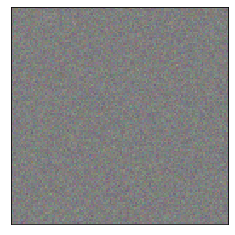

In [6]:
input_img = make_random_image()

plt.imshow(input_img.astype('uint8'))
plt.xticks([])
plt.yticks([])
plt.show()

---
### b. Get Layer by Name

function to find a layer object given a model and layer name 

In [0]:
def find_layer(model, layer_name):
    for layer in model.layers:
        if layer.name == layer_name:
            return layer
    return None

---
### c. Convert to Image

Function to convert result data into 0-255 image data

In [0]:
def convert_to_image(x):
    # normalize data
    # set the std to 0.1 and the mean to 0.5
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

---
---

# [Part 2] Filter Visualization


---
## 1 - Layer Visualization Function

---
#### <font color='red'>**EXERCISE:** </font>

Implement this function. 
* Perform gradient ascent using keras backend to generate filter visualization


In [0]:
def visualize_layer(model, layer_name, filter_index, input_img, steps=50, step_size=1.0):
    
    # get layer from model based on layer_name 
    # by calling find_layer() function with input model and layer_name
    layer = find_layer(model, layer_name)
    
    # maximize the mean activation of the filter of the layer
    activation = K.mean(layer.output[:, :, :, filter_index])
    
    # backward pass
    # calculate gradients of the activations of the filter of the layer
    # call K.gradients() function with input activation and model.input
    grads = K.gradients(activation, model.input)

    
    # get the gradient value
    grads = grads[0]
    
    # normalize the gradients to avoid very small/large gradients
    # normalized gradients is the old gradient divided by Root-Mean-Square of the gradients
    # add small number (e.g. 1e-5) in the division to avoid division by zero
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # create function to calculate the mean activation 
    # and the gradients which depend on the mean activation
    step_function  = K.function([model.input], [activation, grads])
        
    # adjust input image suitable for the calculate function
    input_img = np.copy(input_img)                         # make a copy to preserve the original
    input_img = np.float64(input_img)                      # make sure it's float type
    input_data = input_img.reshape((1, *input_img.shape))  # reshape to one record image data

    # maximize the activation using the gradient ascent
    # (nudge the image data with the gradients)
    for i in range(steps):
        _, grads_value = step_function([input_data])
        input_data += grads_value * step_size
    result = input_data[0]
    
    # convert the result into image using convert_to_image() function
    image_result = convert_to_image(result)
    
    
    return image_result

---
## 2 - Visualize a Filter

The following is an example of an input image that strongly activates the first filter in the layer `block4_conv1`.

You can change the `layer_name` and `filter_index`


In [0]:
layer_name   = 'block4_conv1'
filter_index = 0
input_img    = make_random_image()


result = visualize_layer(model, 
                         layer_name=layer_name, 
                         filter_index=filter_index, 
                         input_img=input_img)


Visualize the filter

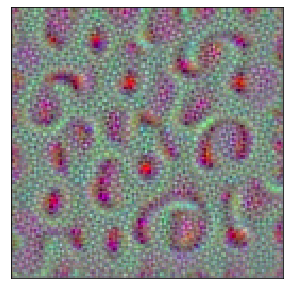

In [14]:
plt.figure(figsize=(15,5))
plt.imshow(result)
plt.xticks([])
plt.yticks([])
plt.show()

---
## 3 - Visualize 20 Filters
Let's examine some filters in a layer. In the function below, we're going to select 20 filters randomly, and view it's visualization

In [0]:
def show_filters(model, layer_name, steps=80):
  
    input_img = make_random_image()
    print('Showing 20 random filters for layer', layer_name)
    plt.figure(figsize=(16,16))
    num_filter = find_layer(model, 'block5_conv3').output.shape[3]
    
    for i in range(20):
        idx = np.random.randint(0,num_filter)
        result = visualize_layer(model, layer_name, filter_index=idx, input_img=input_img, steps=steps)    
        plt.subplot(4, 5, i+1)
        plt.imshow(result)
        plt.gca().set_title(idx)
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout()
    plt.show()

Visualize the filter

Showing 20 random filters for layer block4_conv3


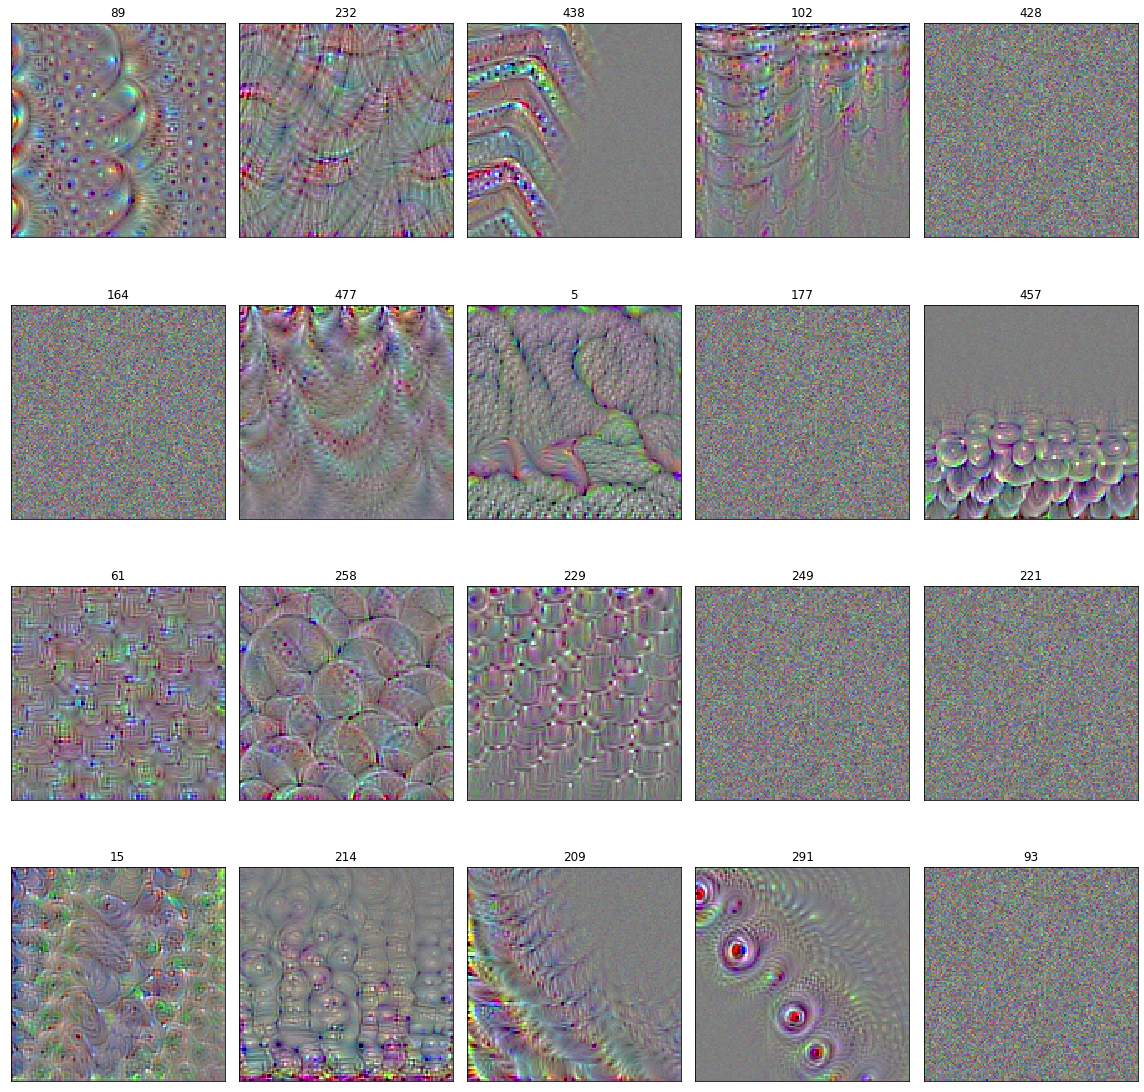

In [16]:
layer_name   = 'block4_conv3'

show_filters(model, layer_name, steps=80)

---
---
# [Part 3] VGG Face Visualization

Now for comparison, Here you are provided a vgg model that has been trained on face dataset.

The model was trained to perform various task from face detection to face recognition

So it made sense that the filters will form facial attributes

---
## 1 - Load VGG Face

Download and load the model provided



In [0]:
!wget -O 'vgg_face_notop.h5' 'https://github.com/CNN-ADF/Task2019/raw/master/resources/vgg_face_notop.h5' -q

In [18]:
from tensorflow.keras.models import load_model

face_model = load_model('vgg_face_notop.h5')

face_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

---
## 2 - Visualize 20 Filters
Let's examine some filters in a layer. In the function below, we're going to select 20 filters randomly, and view it's visualization

WARNING,<br>
you may see some disturbing features 	(￣ヘ￣)

Showing 20 random filters for layer block5_conv2


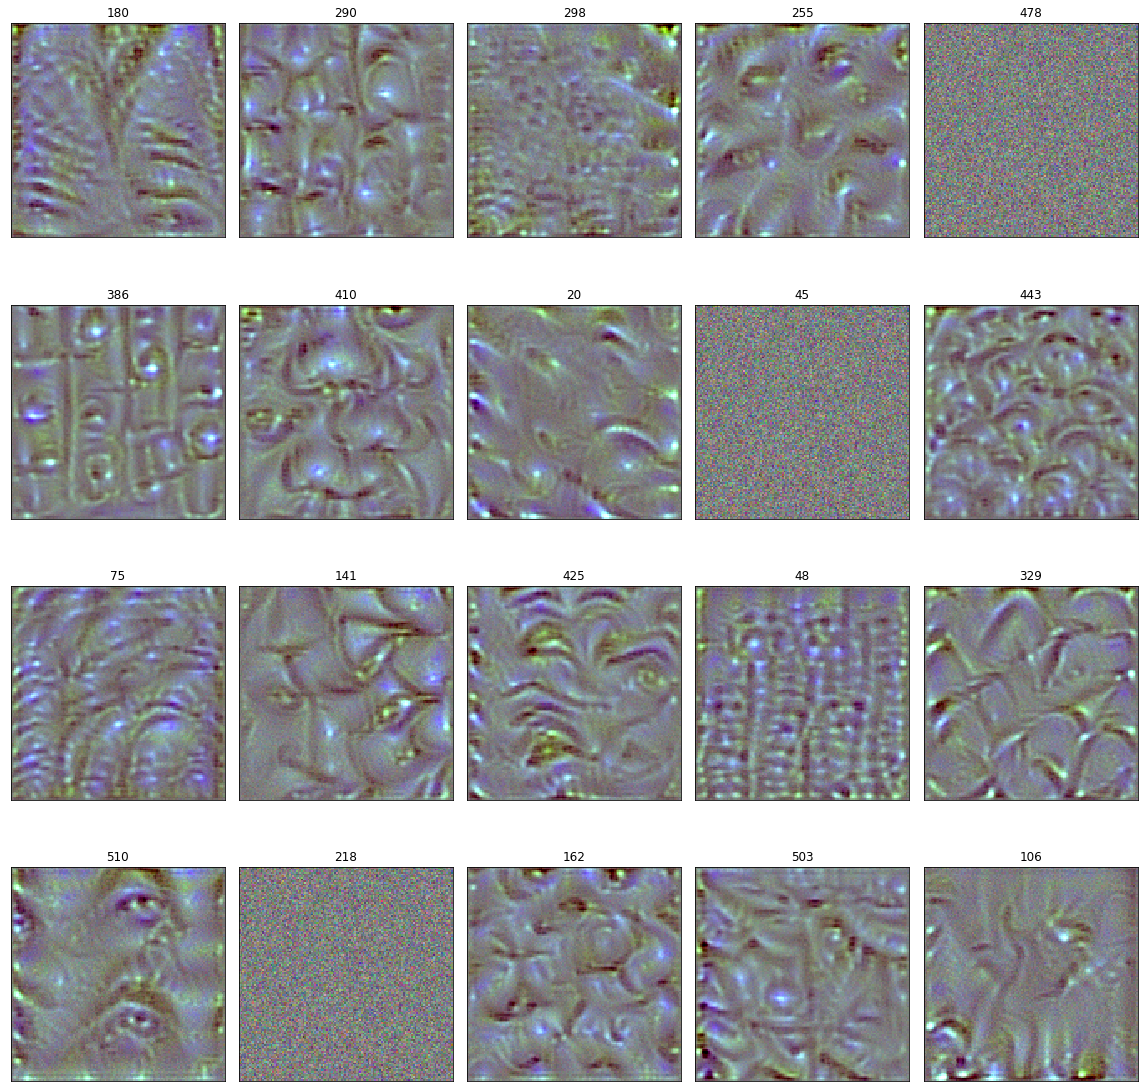

In [19]:
layer_name   = 'block5_conv2'

show_filters(face_model, layer_name, steps=80)

---
---
# [Part 4] Little Deep Dreams

If we throw a Sky image into this experiment and let a filter to nudge the image, what do we get?

This is a similar idea used in **Inceptionism: Going Deeper into Neural Networks** [3].

---
## 1 - Load Image

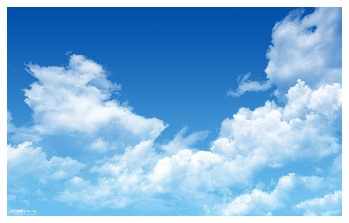

In [20]:
!wget -O 'sky1024px.jpg' 'https://images.squarespace-cdn.com/content/57c8515459cc68fba78d9781/1494175003092-5PQRBFQHQ31HXEWW9O07/sky1024px.jpg' -q


sky_img = plt.imread('sky1024px.jpg') 
plt.imshow(sky_img)
plt.axis('off')
plt.show()

---
## 2 - Hallucinate the Image

Now we perform the filter visualization to the image.

It will, in sense, hallucinate the appearance of the selected filters inside the image

In [0]:
layer_name='block5_conv2'
filter_index=15

result = visualize_layer(model, 
                         layer_name=layer_name,
                         filter_index=filter_index, 
                         input_img=sky_img, 
                         steps=100)



Visualize the result

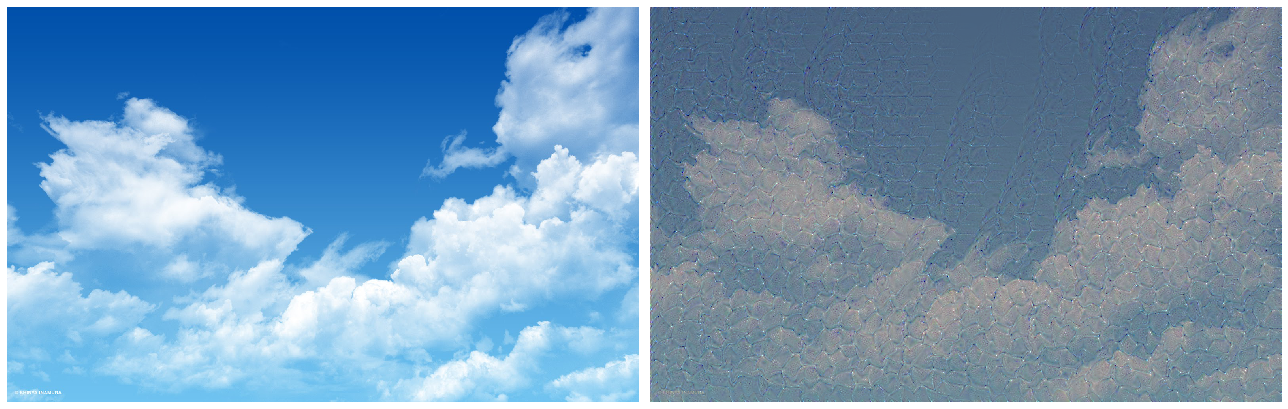

In [22]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(sky_img)
plt.axis('off')
plt.subplot(122)
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()

---
## 3 - Hallucinate the Image using VGG Face

Now let's try to hallucinate the image using VGG Face Model

In [0]:
layer_name='block5_conv2'
filter_index=153

result = visualize_layer(face_model, 
                         layer_name=layer_name,
                         filter_index=filter_index, 
                         input_img=sky_img, 
                         steps=100)



Visualize the result

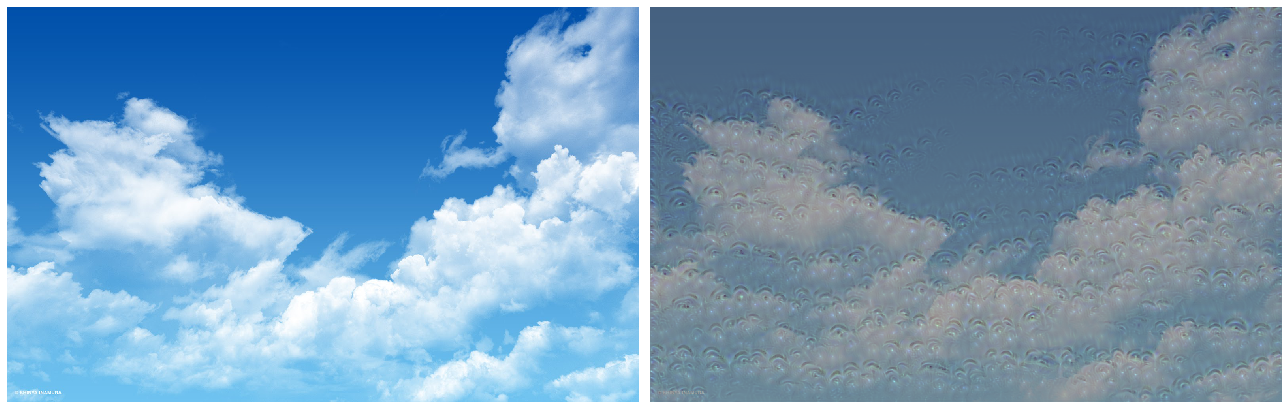

In [24]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(sky_img)
plt.axis('off')
plt.subplot(122)
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()

---
---
# [Part 4] Deep Dreams using Inception V3

To build a better Deep Dream Image, let's use InceptionV3 model for this exercise


---
## 1 - Load Inception Model

Here we load InceptionV3 model that was trained on Imagenet

In [25]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array

model = InceptionV3(weights='imagenet',include_top=False)

# model.summary()

87916544/87910968 [==============================] - 1s 0us/step


---
## 2 - Helper Function
Notice that using previous helper function, the image result became darker

To clear the image, we prepare another helper function

Deep Dream function from google achieve better result by hallucinating the image in different scaling size with multiple filters. For that we prepare resize function for the image

In [0]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

---
## 3 - Feature List

Now, define list of filter that will be used to hallucinate the image

You can change or add the feature and coefficient to use. 

See the list of layer name in `summary()` method

In [0]:
dream_filter = {
    'features': {
        'mixed2' : 0.2,
        'mixed4' : 1.5,
        'mixed5' : 1.0,
        'mixed8' : 3.3,
        'mixed10': 2.5,
    },
}

---
## 4 - Deep Dream Function

---
#### <font color='red'>**EXERCISE:** </font>

Complete this function. 


In [0]:
def deep_dream(model, input_img_path, steps=20, step_size=0.01):
    
    K.set_learning_phase(0)

    img = preprocess_image(input_img_path)
    original_shape = img.shape[1:3]
    successive_shapes = [original_shape]
    
    loss = 0
    
    for layer_name in dream_filter['features']:
    
        # get layer object from model based on layer_name 
        # by calling find_layer() function with input layer_name
        layer = find_layer(model, layer_name)
        
        # get coefficient for features in each layer
        coeff = dream_filter['features'][layer_name]
        
        # define scaling for loss function
        scaling = K.prod(K.cast(K.shape(layer.output), 'float32'))
        
        # define loss function
        loss += coeff * K.sum(K.square(layer.output[:, 2: -2, 2: -2, :])) / scaling
     
    # backward pass
    # calculate gradients of the activations of the filter of the layer
    # call K.gradients() function with input loss and model.input
    grads = K.gradients(loss, model.input)
    
    # get the gradient value
    grads = grads[0]
    
    # normalize the gradients to avoid very small/large gradients
    grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
    
    # create function to calculate total loss
    step_function  = K.function([model.input], [loss, grads])
        
    
    # prepare setting for scaling process
    num_octave = 5           # Number of scales at which to run gradient ascent
    octave_scale = 1.5       # Size ratio between scales    
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
        successive_shapes.append(shape)   
    successive_shapes = successive_shapes[::-1]
    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0])   
    
    # perform Deep Dream in multiple image scale
    for shape in successive_shapes:        
        print('Processing image shape', shape)
        
        # resize image by calling resize_img() function with input img and shape
        img = resize_img(img, shape)
        
        # perform gradient ascent
        for i in range(steps):
            _, grad_value = step_function([img])
            img += grad_value * step_size
        
        # resize back image
        upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
        same_size_original = resize_img(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img

        # hallucinate the image by adding the lost_detail to img
        img = img + lost_detail
        
        
        # resize original image by calling resize_img() function 
        # with input original_img and shape
        shrunk_original_img = resize_img(original_img, shape)
        
    
    # convert the result into image by calling deprocess_image() function with input img
    # image_result = deprocess_image(np.copy(img))
    image_result = deprocess_image(img)    
    
    return image_result

---
## 5 - Perform Deep Dream

In [29]:
result = deep_dream(model, 'sky1024px.jpg', steps=30)


Processing image shape (197, 316)
Processing image shape (296, 474)
Processing image shape (444, 711)
Processing image shape (666, 1066)
Processing image shape (1000, 1600)


/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Visualize the result

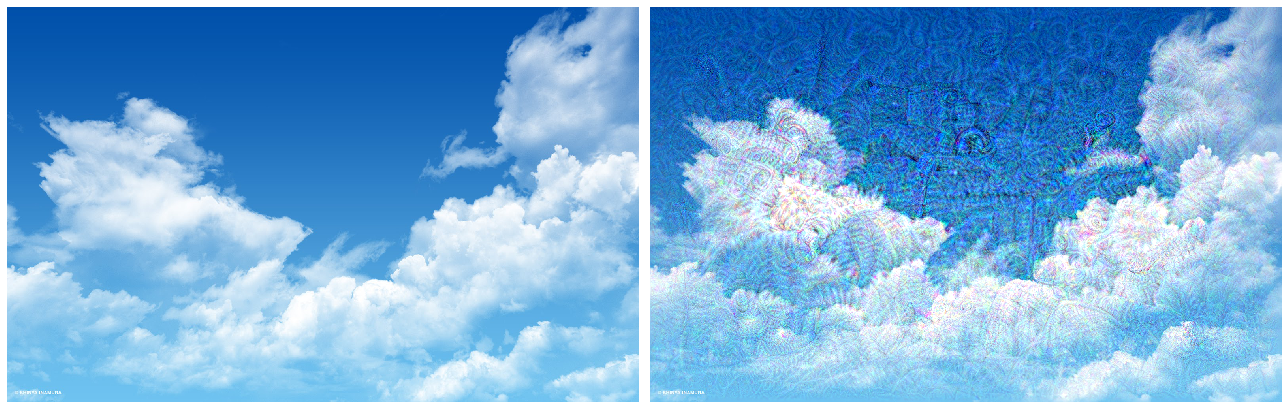

In [30]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(sky_img)
plt.axis('off')

plt.subplot(122)
plt.imshow(result)
plt.axis('off')
plt.tight_layout()

plt.show()

---
---

# Congratulation, You've Completed Exercise 13 part 2

![footer](https://image.ibb.co/hAHDYK/footer2018.png)